# LSTM Intent Classification
---
**Dataset:** bbc news (2225 samples) News contents with 5 categories (Sport, Business, Politics, Tech and Others)

**Model:**   multiclass classification model : LSTM

**Training:**  Colab (GPU)  

**Process:**  1. Dataset Load  ➔ 2. Data processing ➔ 3. Model Training  ➔ 4. Model Evaluation ➔ 5. Prediction

**Result:**  Accuracy = 0.63, run time = 9 minutes

## ライブラリ

In [0]:
#　ライブラリ

import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## 1. データ読み込

In [0]:
# google driveと接続

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# intent, unique_intent, sentencesに分ける

def load_dataset(filename):
  df = pd.read_csv(filename, encoding = "latin1", header=0)
  print(df.head())
  category = df["category"]
  unique_category = list(set(category))
  text = list(df["text"])
  
  return (df, category, unique_category, text)

In [0]:
# データ読み込

dataset = "/content/drive/My Drive/dataset/bbc/bbc-text.csv"
df, category, unique_category, text = load_dataset(dataset)

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...


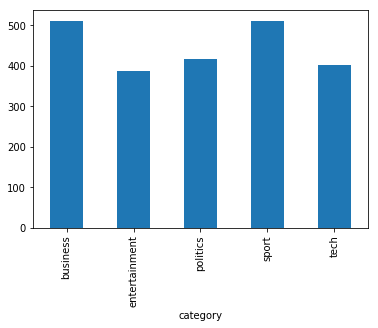

In [0]:
import matplotlib.pyplot as plt

df.groupby('category').text.count().plot.bar(ylim=0)
plt.show()

In [0]:
# サンプルデータを確認

print(text[:5])

['tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to hig

## 2. データ準備

In [0]:
# nltkのstopwordsとtokenizersを読み込む

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
#define stemmer
stemmer = LancasterStemmer()

In [0]:
# データクリーニング

def cleaning(text):
  words = []
  for s in text:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    #stemming
    words.append([i.lower() for i in w])
    
  return words

cleaned_words = cleaning(text)
print(len(cleaned_words))
print(cleaned_words[:2])  

2225
[['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high', 'definition', 'tvs', 'and', 'digital', 'video', 'recorders', 'moving', 'into', 'the', 'living', 'room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer', 'electronics', 'show', 'in', 'las', 'vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service', 'providers', 'to', 'front', 'rooms', 'and', 'portable', 'devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces'

In [0]:
# Tokenizerを作成

def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

# max_lengthの設定
def max_length(words):
  return(len(max(words, key = len)))


word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
# max_length = max_length(cleaned_words)
max_length = 100

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 29457 and Maximum length = 100


In [0]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

padded_doc = padding_doc(encoded_doc, max_length)

In [0]:
padded_doc[:5]

array([[ 8835,     4,   686,  4199,    50,     3,     1,    49,     7,
          335,  2201,   178,   223, 19461,    19,   191,   744,    43,
          207,  3130,  8835,    21,     1,   149,    17,   529,   807,
            3,  2554,  3923,  5272,  3591,     4,     5,   502,  4857,
            1,   112,    52,  4660,     4,  9763,   178,     8,    42,
            2,  1866,   807,     4,   387,   208,   379,  2888,   440,
            6,    30,   752,   149,  4064,   858,     5,  3812,    17,
         5532,   252, 19462,    35,   510,    47,    52,   160,  1867,
         1146,    12,   920,   970,     4,   170,   707,    58,   184,
         3211,     1,  1474,  1669,     3,  9764,    42,  1758,    73,
           10,    47,    52,  1044,    74,    29,   166,    66,    29,
          166],
       [   25,   412,     2,  8130,   132,    18,    34, 19463,   708,
           46,    22,    30,   207,  5536,     9,    40, 10927,  7556,
           57,  1530,  2385,    30,  8841,    32,  1742,  585

In [0]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (2225, 100)


In [0]:
# tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_category, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')


In [0]:
output_tokenizer.word_index

{'business': 4, 'entertainment': 5, 'politics': 1, 'sport': 2, 'tech': 3}

In [0]:
# Tokenizer

encoded_output = encoding_doc(output_tokenizer, category)

encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

encoded_output.shape

(2225, 1)

In [0]:
# one hot encoder

def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

output_one_hot = one_hot(encoded_output)

output_one_hot.shape

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(2225, 5)

In [0]:
# 学習とテストを分ける

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_doc, output_one_hot, shuffle = True,  stratify = category, test_size = 0.2, random_state=11)

print("Shape of X_train = %s and y_train = %s" % (X_train.shape, y_train.shape))
print("Shape of X_test = %s and y_test = %s" % (X_test.shape, y_test.shape))


Shape of X_train = (1780, 100) and y_train = (1780, 5)
Shape of X_test = (445, 100) and y_test = (445, 5)


## 3. 学習

In [0]:
# モデルの設定

def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.7))
  model.add(Dense(5, activation = "softmax"))
  
  return model

model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

W0718 04:58:14.623856 140625997510528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 04:58:14.647878 140625997510528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 04:58:14.653760 140625997510528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 04:58:15.351450 140625997510528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0718 04:58:15.364298 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          3770496   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 4,042,053
Trainable params: 271,557
Non-trainable params: 3,770,496
_________________________________________________________________


In [0]:
# モデル学習
from datetime import datetime

start_time = datetime.now()

filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(X_train, y_train, epochs = 120, batch_size = 178, validation_data = (X_test, y_test), callbacks = [checkpoint])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

W0718 04:58:15.616575 140625997510528 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1780 samples, validate on 445 samples
Epoch 1/120
1780/1780 [==============================] - 7s 4ms/step - loss: 1.6073 - acc: 0.2247 - val_loss: 1.6044 - val_acc: 0.2404

Epoch 00001: val_loss improved from inf to 1.60439, saving model to model.h5
Epoch 2/120
1780/1780 [==============================] - 4s 2ms/step - loss: 1.6018 - acc: 0.2213 - val_loss: 1.5999 - val_acc: 0.2697

Epoch 00002: val_loss improved from 1.60439 to 1.59988, saving model to model.h5
Epoch 3/120
1780/1780 [==============================] - 4s 2ms/step - loss: 1.5974 - acc: 0.2421 - val_loss: 1.5980 - val_acc: 0.2854

Epoch 00003: val_loss improved from 1.59988 to 1.59804, saving model to model.h5
Epoch 4/120
1780/1780 [==============================] - 4s 2ms/step - loss: 1.5941 - acc: 0.2449 - val_loss: 1.5920 - val_acc: 0.2360

Epoch 00004: val_loss improved from 1.59804 to 1.59200, saving model to model.h5
Epoch 5/120
1780/1780 [==============================] - 4s 3ms/step - loss: 1.5715 - acc

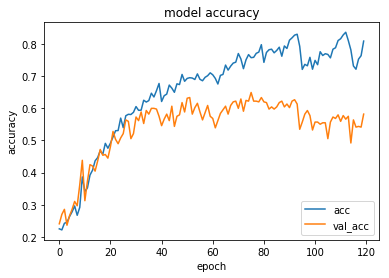

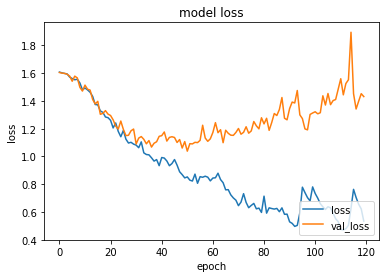

In [0]:
def plot_history(hist):
    #print(hist.history.keys())

    # 精度の履歴をプロット
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

# 学習履歴をプロット
plot_history(hist)

In [0]:
# モデルの設定

model = load_model("model.h5")

W0718 05:07:15.313939 140625997510528 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [0]:
#ytest = np.array(y_test)
ytest = np.argmax(y_test, axis=1)
pd = model.predict(X_test)
prediction = pd.argmax(1)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

#ytest = np.array(y_test)
ytest = np.argmax(y_test, axis=1)
pd = model.predict(X_test)
prediction = pd.argmax(1)


# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, prediction))
print(confusion_matrix(ytest, prediction))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64        84
           1       0.64      0.76      0.70       102
           2       0.61      0.72      0.66        80
           3       0.66      0.53      0.59       102
           4       0.60      0.48      0.53        77

    accuracy                           0.63       445
   macro avg       0.63      0.63      0.62       445
weighted avg       0.63      0.63      0.63       445

[[54  9  8  9  4]
 [ 2 78  5  4 13]
 [ 8  3 58  8  3]
 [14 13 16 54  5]
 [ 7 18  8  7 37]]


In [0]:
from sklearn.metrics import accuracy_score


accuracy = accuracy_score(ytest, prediction)
accuracy

0.6314606741573033

## 4. 推論

In [0]:
# 推論のスクリプト

def predictions(text):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  print(test_word)
  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
  x = padding_doc(test_ls, max_length)
  
  pred = model.predict_proba(x)
  
  return pred


def get_final_output(pred, classes):
  predictions = pred[0]
 
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))


In [0]:
# テスト

text = "New movie in this summer"
pred = predictions(text)
get_final_output(pred, unique_category)

['new', 'movie', 'in', 'this', 'summer']
entertainment has confidence = 0.99992347
politics has confidence = 5.523028e-05
sport has confidence = 1.8991259e-05
tech has confidence = 2.3080001e-06
business has confidence = 4.4786788e-08
